Transformer详细架构
===

# 1.输入部分
输入部分包括以下两部分
- 源文本嵌入层及其位置编码器
- 目标文本嵌入层及其位置编码器

![images](images/025.png)

## 1.1.文本嵌入层的作用
无论是源文本嵌入还是目标文本嵌入，都是为了将文本中词汇的数字表示转变为向量表示, 希望在这样的高维空间捕捉词汇间的关系.

In [12]:
import torch

embedding = torch.nn.Embedding(10, 3)
input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
embedding(input)

tensor([[[-1.1868,  2.1471, -0.2209],
         [ 0.2490, -0.5537,  0.4563],
         [ 0.2120, -0.4274,  0.5179],
         [-0.2169,  0.0243,  0.7470]],

        [[ 0.2120, -0.4274,  0.5179],
         [-0.7586,  0.4682, -0.0301],
         [ 0.2490, -0.5537,  0.4563],
         [ 0.7559,  0.7842, -0.6098]]], grad_fn=<EmbeddingBackward>)

In [13]:
from lib.Embeddings import Embeddings
# 词嵌入维度是512维
d_model = 512
# 词表大小是1000
vocab = 1000
# 输入x是一个使用Variable封装的长整型张量, 形状是2 x 4
x = torch.autograd.Variable(torch.LongTensor([[100,2,421,508],[491,998,1,221]]))
emb = Embeddings(d_model, vocab)
embr = emb(x)
print("embr:", embr)

embr: tensor([[[-47.1886,  14.5286,  39.7122,  ...,   2.5406,  20.2207,  -9.5474],
         [ 23.3596,  12.9102,  22.5903,  ...,  -1.1937,   1.4142,  33.1731],
         [-19.4604,  -8.1573,  18.7390,  ...,   5.8599,  -3.9852, -36.3737],
         [ -4.4510,   0.2926,   0.1516,  ...,  -4.5531,  -6.7267,  15.4763]],

        [[ -7.6151, -52.3656, -17.5181,  ...,  -6.2177, -34.5336, -29.8499],
         [ -0.1812,  20.6850,  -4.4372,  ...,  -8.0780,   5.8309,  -0.0755],
         [-24.9506, -25.1096,  57.8336,  ...,   8.1278, -13.6669,  18.7870],
         [-24.2203,  30.3387, -27.3709,  ..., -14.5281,  10.2089, -13.6989]]],
       grad_fn=<MulBackward0>)


## 1.2.位置编码器的作用
因为在Transformer的编码器结构中, 并没有针对词汇位置信息的处理，因此需要在Embedding层后加入位置编码器，将词汇位置不同可能会产生不同语义的信息加入到词嵌入张量中, 以弥补位置信息的缺失.

In [14]:
m = torch.nn.Dropout(p=0.2)
input = torch.randn(4, 5)
output = m(input)
output

tensor([[-0.0000,  0.8141,  0.7919, -0.0532,  1.1496],
        [-0.9502, -0.8604,  0.1918, -1.5276, -0.0000],
        [ 0.4006,  0.3943, -0.8051,  0.7956, -0.7611],
        [ 0.6297, -0.0000, -1.4482,  1.4607,  0.9984]])

In [15]:
from lib.PositionalEncoding import PositionalEncoding
# 词嵌入维度是512维
d_model = 512
# 置0比率为0.1
dropout = 0.1
# 句子最大长度
max_len=60
# 输入x是Embedding层的输出的张量, 形状是2 x 4 x 512
x = embr
pe = PositionalEncoding(d_model, dropout, max_len)
pe_result = pe(x)
print("pe_result:", pe_result)

pe_result: tensor([[[-52.4318,  17.2540,  44.1247,  ...,   3.9340,   0.0000,  -9.4971],
         [  0.0000,  14.9450,  26.0135,  ...,  -0.2152,   0.0000,  37.9701],
         [-20.6124,  -9.5260,  21.8616,  ...,   7.6221,  -0.0000, -39.3042],
         [ -4.7888,  -0.0000,   0.4408,  ...,  -3.9479,  -7.4738,  18.3070]],

        [[ -8.4612, -57.0729,  -0.0000,  ...,  -5.7975, -38.3707, -32.0555],
         [  0.0000,  23.5837,  -4.0171,  ...,  -7.8644,   6.4789,   1.0273],
         [-26.7126, -28.3619,  65.3000,  ...,  10.1419, -15.1852,  21.9855],
         [-26.7546,  32.6097,  -0.0000,  ..., -15.0312,  11.3436, -14.1099]]],
       grad_fn=<MulBackward0>)


## 1.3.绘制词汇向量中特征的分布曲线

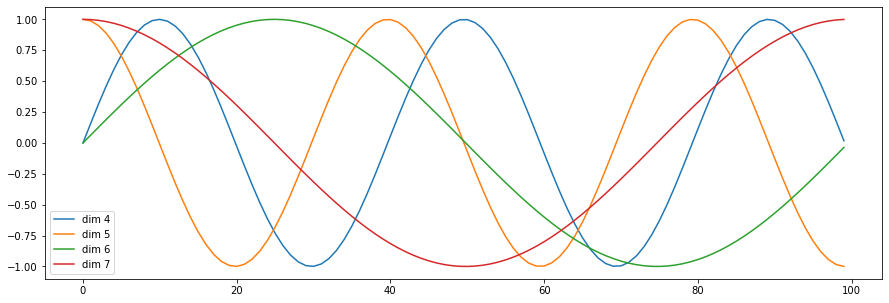

In [16]:
import matplotlib.pyplot as plt
import numpy as np
# 创建一张15 x 5大小的画布
plt.figure(figsize=(15, 5))

# 实例化PositionalEncoding类得到pe对象, 输入参数是20和0
pe = PositionalEncoding(20, 0)

# 然后向pe传入被Variable封装的tensor, 这样pe会直接执行forward函数, 
# 且这个tensor里的数值都是0, 被处理后相当于位置编码张量
y = pe(torch.autograd.Variable(torch.zeros(1, 100, 20)))

# 然后定义画布的横纵坐标, 横坐标到100的长度, 纵坐标是某一个词汇中的某维特征在不同长度下对应的值
# 因为总共有20维之多, 我们这里只查看4，5，6，7维的值.
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())

# 在画布上填写维度提示信息
plt.legend(["dim %d"%p for p in [4,5,6,7]])

# 2.编码器部分

## 2.1.构成
- 由N个编码器层堆叠而成
- 每个编码器层由两个子层连接结构组成
- 第一个子层连接结构包括一个多头自注意力子层和规范化层以及一个残差连接
- 第二个子层连接结构包括一个前馈全连接子层和规范化层以及一个残差连接

![images](images/026.png)

## 2.2.掩码张量
掩代表遮掩，码就是我们张量中的数值，它的尺寸不定，里面一般只有1和0的元素，代表位置被遮掩或者不被遮掩，至于是0位置被遮掩还是1位置被遮掩可以自定义，因此它的作用就是让另外一个张量中的一些数值被遮掩，也可以说被替换, 它的表现形式是一个张量.

在transformer中, 掩码张量的主要作用在应用attention(将在下一小节讲解)时，有一些生成的attention张量中的值计算有可能已知了未来信息而得到的，未来信息被看到是因为训练时会把整个输出结果都一次性进行Embedding，但是理论上解码器的的输出却不是一次就能产生最终结果的，而是一次次通过上一次结果综合得出的，因此，未来的信息可能被提前利用. 

In [17]:
def subsequent_mask(size):
    """生成向后遮掩的掩码张量, 参数size是掩码张量最后两个维度的大小, 它的最后两维形成一个方阵"""
    # 在函数中, 首先定义掩码张量的形状
    attn_shape = (1, size, size)

    # 然后使用np.ones方法向这个形状中添加1元素,形成上三角阵, 最后为了节约空间, 
    # 再使其中的数据类型变为无符号8位整形unit8 
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')

    # 最后将numpy类型转化为torch中的tensor, 内部做一个1 - 的操作, 
    # 在这个其实是做了一个三角阵的反转, subsequent_mask中的每个元素都会被1减, 
    # 如果是0, subsequent_mask中的该位置由0变成1
    # 如果是1, subsequent_mask中的该位置由1变成0 
    return torch.from_numpy(1 - subsequent_mask)

In [18]:
np.triu([[1,2,3],[4,5,6],[7,8,9],[10,11,12]], k=0)

array([[1, 2, 3],
       [0, 5, 6],
       [0, 0, 9],
       [0, 0, 0]])

sm: tensor([[[1, 0, 0, 0, 0],
         [1, 1, 0, 0, 0],
         [1, 1, 1, 0, 0],
         [1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1]]], dtype=torch.uint8)


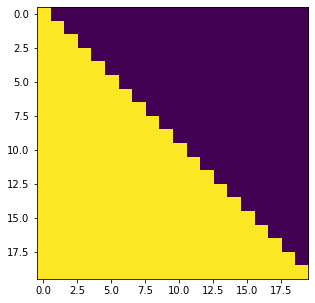

In [19]:
# 生成的掩码张量的最后两维的大小
size = 5
sm = subsequent_mask(size)
print("sm:", sm)
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

## 2.3.注意力机制
我们观察事物时，之所以能够快速判断一种事物(当然允许判断是错误的), 是因为我们大脑能够很快把注意力放在事物最具有辨识度的部分从而作出判断，而并非是从头到尾的观察一遍事物后，才能有判断结果. 正是基于这样的理论，就产生了注意力机制.

### 2.3.1.注意力计算规则
它需要三个指定的输入Q(query), K(key), V(value), 然后通过公式得到注意力的计算结果, 这个结果代表query在key和value作用下的表示. 而这个具体的计算规则有很多种, 我这里只介绍我们用到的这一种.

$$
Attention(Q,K,V)=softmax(\frac{QK^T}{\sqrt{d_k}})V
$$

假如我们有一个问题: 给出一段文本，使用一些关键词对它进行描述!为了方便统一正确答案，这道题可能预先已经给大家写出了一些关键词作为提示.其中这些给出的提示就可以看作是key， 而整个的文本信息就相当于是query，value的含义则更抽象，可以比作是你看到这段文本信息后，脑子里浮现的答案信息，这里我们又假设大家最开始都不是很聪明，第一次看到这段文本后脑子里基本上浮现的信息就只有提示这些信息，因此key与value基本是相同的，但是随着我们对这个问题的深入理解，通过我们的思考脑子里想起来的东西原来越多，并且能够开始对我们query也就是这段文本，提取关键信息进行表示.  这就是注意力作用的过程， 通过这个过程，我们最终脑子里的value发生了变化，根据提示key生成了query的关键词表示方法，也就是另外一种特征表示方法.刚刚我们说到key和value一般情况下默认是相同，与query是不同的，这种是我们一般的注意力输入形式，但有一种特殊情况，就是我们query与key和value相同，这种情况我们称为自注意力机制，就如同我们的刚刚的例子， 使用一般注意力机制，是使用不同于给定文本的关键词表示它. 而自注意力机制,需要用给定文本自身来表达自己，也就是说你需要从给定文本中抽取关键词来表述它, 相当于对文本自身的一次特征提取.

注意力机制是注意力计算规则能够应用的深度学习网络的载体, 除了注意力计算规则外, 还包括一些必要的全连接层以及相关张量处理, 使其与应用网络融为一体. 使用自注意力计算规则的注意力机制称为自注意力机制.

![images](images/027.png)

In [20]:
from lib.Attention import attention
# 我们令输入的query, key, value都相同, 位置编码的输出
query = key = value = pe_result
attn, p_attn = attention(query, key, value)
print("attn:", attn)
print("p_attn:", p_attn)

attn: tensor([[[-52.4318,  17.2540,  44.1247,  ...,   3.9340,   0.0000,  -9.4971],
         [  0.0000,  14.9450,  26.0135,  ...,  -0.2152,   0.0000,  37.9701],
         [-20.6124,  -9.5260,  21.8616,  ...,   7.6221,   0.0000, -39.3042],
         [ -4.7888,   0.0000,   0.4408,  ...,  -3.9479,  -7.4738,  18.3070]],

        [[ -8.4612, -57.0729,   0.0000,  ...,  -5.7975, -38.3707, -32.0555],
         [  0.0000,  23.5837,  -4.0171,  ...,  -7.8644,   6.4789,   1.0273],
         [-26.7126, -28.3619,  65.3000,  ...,  10.1419, -15.1852,  21.9855],
         [-26.7546,  32.6097,   0.0000,  ..., -15.0312,  11.3436, -14.1099]]],
       grad_fn=<UnsafeViewBackward>)
p_attn: tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], grad_fn=<SoftmaxBackward>)


In [22]:
# 带有mask的输入参数
query = key = value = pe_result
# 令mask为一个2x4x4的零张量
mask = torch.autograd.Variable(torch.zeros(2, 4, 4))
attn, p_attn = attention(query, key, value, mask=mask)
print("attn:", attn)
print("p_attn:", p_attn)

attn: tensor([[[-19.4582,   5.6683,  23.1101,  ...,   1.8482,  -1.8684,   1.8690],
         [-19.4582,   5.6683,  23.1101,  ...,   1.8482,  -1.8684,   1.8690],
         [-19.4582,   5.6683,  23.1101,  ...,   1.8482,  -1.8684,   1.8690],
         [-19.4582,   5.6683,  23.1101,  ...,   1.8482,  -1.8684,   1.8690]],

        [[-15.4821,  -7.3104,  15.3207,  ...,  -4.6378,  -8.9334,  -5.7882],
         [-15.4821,  -7.3104,  15.3207,  ...,  -4.6378,  -8.9334,  -5.7882],
         [-15.4821,  -7.3104,  15.3207,  ...,  -4.6378,  -8.9334,  -5.7882],
         [-15.4821,  -7.3104,  15.3207,  ...,  -4.6378,  -8.9334,  -5.7882]]],
       grad_fn=<UnsafeViewBackward>)
p_attn: tensor([[[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 

## 2.4.多头注意力机制
从多头注意力的结构图中，貌似这个所谓的多个头就是指多组线性变换层，其实并不是，我只有使用了一组线性变化层，即三个变换张量对Q，K，V分别进行线性变换，这些变换不会改变原有张量的尺寸，因此每个变换矩阵都是方阵，得到输出结果后，多头的作用才开始显现，每个头开始从词义层面分割输出的张量，也就是每个头都想获得一组Q，K，V进行注意力机制的计算，但是句子中的每个词的表示只获得一部分，也就是只分割了最后一维的词嵌入向量. 这就是所谓的多头，将每个头的获得的输入送到注意力机制中, 就形成多头注意力机制.

![images](images/028.png)

这种结构设计能让每个注意力机制去优化每个词汇的不同特征部分，从而均衡同一种注意力机制可能产生的偏差，让词义拥有来自更多元的表达，实验表明可以从而提升模型效果.

In [23]:
from lib.MultiHeadedAttention import MultiHeadedAttention
# 头数head
head = 8
# 词嵌入维度embedding_dim
embedding_dim = 512
# 置零比率dropout
dropout = 0.2
# 假设输入的Q，K，V仍然相等
query = value = key = pe_result
# 输入的掩码张量mask
mask = torch.autograd.Variable(torch.zeros(8, 4, 4))
mha = MultiHeadedAttention(head, embedding_dim, dropout)
mha_result = mha(query, key, value, mask)
print(mha_result)

tensor([[[10.4999, -2.1685, -8.6798,  ..., -2.2072, -1.4880, -2.3767],
         [ 1.4204, -1.9239, -8.4465,  ..., -1.9163, -3.0659, -2.1721],
         [ 8.8615, -2.0725, -7.2343,  ..., -6.0071, -2.1366, -2.5655],
         [ 6.3234, -0.9000, -7.2403,  ..., -6.9094, -2.9402, -7.7335]],

        [[ 7.3560,  1.9967, -1.0745,  ...,  0.7086,  4.1025,  7.2160],
         [ 3.7177,  1.2989, -3.3704,  ...,  1.8720,  3.4757,  3.8960],
         [ 5.8622, -4.5272, -4.5656,  ...,  4.6084,  5.4872,  2.0783],
         [ 6.2889,  1.9710, -5.6335,  ...,  6.3365,  4.1208,  5.0568]]],
       grad_fn=<AddBackward0>)


## 2.5.前馈全连接层
在Transformer中前馈全连接层就是具有两层线性层的全连接网络.

In [24]:
from lib.PositionwiseFeedForward import PositionwiseFeedForward
d_model = 512
# 线性变化的维度
d_ff = 64
dropout = 0.2
# 输入参数x可以是多头注意力机制的输出
x = mha_result
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
ff_result = ff(x)
print(ff_result)

tensor([[[ 0.4782, -0.5282, -0.0392,  ..., -0.1227,  0.6766,  0.1773],
         [ 1.0315, -0.6356,  0.2345,  ..., -0.1716, -0.6352,  0.1323],
         [ 1.3128, -0.4863,  0.5067,  ..., -0.4540,  0.0909,  0.6975],
         [ 1.8180,  0.5902, -0.2407,  ..., -0.5333, -1.0152, -0.2041]],

        [[-0.4021, -0.4680,  0.7330,  ...,  0.7935,  0.0535,  0.3139],
         [ 0.4617,  0.5476,  0.7297,  ...,  1.3454,  1.4127,  0.6801],
         [-0.0942, -0.1339,  0.2861,  ...,  0.5409, -1.1329,  1.0530],
         [ 0.1787,  0.0335,  0.4641,  ...,  0.4847, -0.0917,  1.2378]]],
       grad_fn=<AddBackward0>)


## 2.6.规范化层
它是所有深层网络模型都需要的标准网络层，因为随着网络层数的增加，通过多层的计算后参数可能开始出现过大或过小的情况，这样可能会导致学习过程出现异常，模型可能收敛非常的慢. 因此都会在一定层数后接规范化层进行数值的规范化，使其特征数值在合理范围内.

In [26]:
from lib.LayerNorm import LayerNorm
features = d_model = 512
eps = 1e-6
# 输入x来自前馈全连接层的输出
x = ff_result
ln = LayerNorm(features, eps)
ln_result = ln(x)
print(ln_result)

tensor([[[ 0.4194, -0.4911, -0.0487,  ..., -0.1242,  0.5989,  0.1472],
         [ 0.9456, -0.5238,  0.2431,  ..., -0.1148, -0.5234,  0.1531],
         [ 0.9207, -0.3433,  0.3543,  ..., -0.3207,  0.0622,  0.4884],
         [ 1.3525,  0.4513, -0.1586,  ..., -0.3733, -0.7271, -0.1317]],

        [[-0.4295, -0.4930,  0.6636,  ...,  0.7218,  0.0092,  0.2600],
         [ 0.4900,  0.5914,  0.8063,  ...,  1.5327,  1.6122,  0.7477],
         [-0.1517, -0.1967,  0.2788,  ...,  0.5673, -1.3276,  1.1470],
         [ 0.1658,  0.0225,  0.4475,  ...,  0.4677, -0.1010,  1.2110]]],
       grad_fn=<AddBackward0>)


## 2.7.子层连接结构
如图所示，输入到每个子层以及规范化层的过程中，还使用了残差链接（跳跃连接），因此我们把这一部分结构整体叫做子层连接（代表子层及其链接结构），在每个编码器层中，都有两个子层，这两个子层加上周围的链接结构就形成了两个子层连接结构.

![images](images/029.png)  ![images](images/030.png)

In [27]:
from lib.SublayerConnection import SublayerConnection
size = 512
dropout = 0.2
head = 8
d_model = 512
# 令x为位置编码器的输出
x = pe_result
mask = torch.autograd.Variable(torch.zeros(8, 4, 4))
# 假设子层中装的是多头注意力层, 实例化这个类
self_attn =  MultiHeadedAttention(head, d_model)
# 使用lambda获得一个函数类型的子层
sublayer = lambda x: self_attn(x, x, x, mask)
sc = SublayerConnection(size, dropout)
sc_result = sc(x, sublayer)
print(sc_result)
print(sc_result.shape)

tensor([[[-5.2092e+01,  1.7380e+01,  4.3962e+01,  ...,  3.9340e+00,
           9.1142e-02, -9.7153e+00],
         [ 1.8241e-01,  1.5050e+01,  2.5709e+01,  ...,  2.4294e-01,
           2.2336e-03,  3.7798e+01],
         [-2.0414e+01, -9.2445e+00,  2.1695e+01,  ...,  8.1729e+00,
           3.8096e-02, -3.9304e+01],
         [-4.6501e+00,  9.1083e-02,  2.6463e-01,  ..., -3.6298e+00,
          -7.2947e+00,  1.8163e+01]],

        [[-8.1761e+00, -5.7250e+01,  5.3603e-02,  ..., -5.8574e+00,
          -3.8495e+01, -3.2317e+01],
         [ 3.7579e-02,  2.3508e+01, -4.1892e+00,  ..., -7.7053e+00,
           6.4789e+00,  7.7481e-01],
         [-2.6678e+01, -2.8362e+01,  6.5300e+01,  ...,  1.0101e+01,
          -1.5378e+01,  2.1730e+01],
         [-2.6494e+01,  3.2610e+01, -1.9022e-01,  ..., -1.5012e+01,
           1.1170e+01, -1.4110e+01]]], grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


## 2.8.编码器层
作为编码器的组成单元, 每个编码器层完成一次对输入的特征提取过程, 即编码过程.

![images](images/031.png)

In [28]:
from lib.EncoderLayer import EncoderLayer
size = 512
head = 8
d_model = 512
d_ff = 64
x = pe_result
dropout = 0.2
self_attn = MultiHeadedAttention(head, d_model)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
mask = torch.autograd.Variable(torch.zeros(8, 4, 4))
el = EncoderLayer(size, self_attn, ff, dropout)
el_result = el(x, mask)
print(el_result)
print(el_result.shape)

tensor([[[-5.3083e+01,  1.7416e+01,  4.3859e+01,  ...,  4.1747e+00,
          -3.6150e-01, -9.2678e+00],
         [-8.0326e-01,  1.4824e+01,  2.6140e+01,  ..., -2.6156e-01,
          -1.9378e-01,  3.8415e+01],
         [-2.1159e+01, -9.7621e+00,  2.2520e+01,  ...,  7.2282e+00,
          -2.3334e-01, -3.9256e+01],
         [-5.0877e+00, -1.5347e-01,  1.0932e+00,  ..., -3.9479e+00,
          -7.6679e+00,  1.8501e+01]],

        [[-8.3553e+00, -5.7271e+01, -2.5591e-01,  ..., -5.8426e+00,
          -3.8371e+01, -3.2094e+01],
         [-2.8106e-02,  2.3277e+01, -4.7942e+00,  ..., -7.9755e+00,
           6.0796e+00,  1.2025e+00],
         [-2.7003e+01, -2.8610e+01,  6.5462e+01,  ...,  9.6864e+00,
          -1.5063e+01,  2.2137e+01],
         [-2.6840e+01,  3.2311e+01,  0.0000e+00,  ..., -1.5394e+01,
           1.0942e+01, -1.4241e+01]]], grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


## 2.9.编码器
编码器用于对输入进行指定的特征提取过程, 也称为编码, 由N个编码器层堆叠而成.

![images](images/032.png)

In [30]:
from lib.Encoder import Encoder
import copy
# 第一个实例化参数layer, 它是一个编码器层的实例化对象, 因此需要传入编码器层的参数
# 又因为编码器层中的子层是不共享的, 因此需要使用深度拷贝各个对象.
size = 512
head = 8
d_model = 512
d_ff = 64
c = copy.deepcopy
attn = MultiHeadedAttention(head, d_model)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
dropout = 0.2
layer = EncoderLayer(size, c(attn), c(ff), dropout)
# 编码器中编码器层的个数N
N = 8
mask = torch.autograd.Variable(torch.zeros(8, 4, 4))
en = Encoder(layer, N)
en_result = en(x, mask)
print(en_result)
print(en_result.shape)

tensor([[[-2.2355,  0.7092,  2.1110,  ...,  0.1194,  0.2619, -0.3060],
         [-0.2444,  0.5097,  0.9000,  ..., -0.2708, -0.1074,  1.3183],
         [-0.8607, -0.4421,  0.9784,  ...,  0.1472,  0.0966, -1.4926],
         [-0.1269, -0.0136,  0.0243,  ..., -0.2313, -0.2223,  0.7737]],

        [[-0.2902, -2.4639, -0.0148,  ..., -0.1920, -1.5585, -1.3211],
         [-0.0409,  0.8417, -0.2353,  ..., -0.1223,  0.3717,  0.1512],
         [-1.1420, -1.0050,  2.7701,  ...,  0.5511, -0.5594,  0.9453],
         [-1.0440,  1.1583, -0.1498,  ..., -0.5773,  0.5158, -0.5526]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


# 3.解码器部分
- 由N个解码器层堆叠而成
- 每个解码器层由三个子层连接结构组成
- 第一个子层连接结构包括一个多头自注意力子层和规范化层以及一个残差连接
- 第二个子层连接结构包括一个多头注意力子层和规范化层以及一个残差连接
- 第三个子层连接结构包括一个前馈全连接子层和规范化层以及一个残差连接

![images](images/033.png)

## 3.1.解码器层
作为解码器的组成单元, 每个解码器层根据给定的输入向目标方向进行特征提取操作，即解码过程.

In [31]:
from lib.DecoderLayer import DecoderLayer
# 类的实例化参数与解码器层类似, 相比多出了src_attn, 但是和self_attn是同一个类.
head = 8
size = 512
d_model = 512
d_ff = 64
dropout = 0.2
self_attn = src_attn = MultiHeadedAttention(head, d_model, dropout)
# 前馈全连接层也和之前相同 
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
# x是来自目标数据的词嵌入表示, 但形式和源数据的词嵌入表示相同, 这里使用per充当.
x = pe_result

# memory是来自编码器的输出
memory = en_result

# 实际中source_mask和target_mask并不相同, 这里为了方便计算使他们都为mask
mask = torch.autograd.Variable(torch.zeros(8, 4, 4))
source_mask = target_mask = mask
dl = DecoderLayer(size, self_attn, src_attn, ff, dropout)
dl_result = dl(x, memory, source_mask, target_mask)
print(dl_result)
print(dl_result.shape)

tensor([[[-5.1581e+01,  1.7232e+01,  4.4277e+01,  ...,  3.6099e+00,
           1.8196e-01, -9.6366e+00],
         [ 4.1940e-02,  1.5207e+01,  2.5652e+01,  ..., -1.0505e+00,
           9.9937e-01,  3.8130e+01],
         [-2.0556e+01, -1.0226e+01,  2.1482e+01,  ...,  7.4753e+00,
           3.7894e-01, -3.9515e+01],
         [-4.4341e+00, -2.9591e-01,  3.9587e-01,  ..., -4.4623e+00,
          -6.7638e+00,  1.8552e+01]],

        [[-8.4838e+00, -5.7716e+01,  7.7710e-01,  ..., -5.6802e+00,
          -3.8519e+01, -3.1995e+01],
         [ 1.6369e-01,  2.3521e+01, -3.3838e+00,  ..., -7.4372e+00,
           6.3504e+00,  1.4689e+00],
         [-2.6277e+01, -2.8375e+01,  6.6157e+01,  ...,  1.0118e+01,
          -1.5214e+01,  2.1986e+01],
         [-2.6395e+01,  3.2932e+01,  1.2732e+00,  ..., -1.4762e+01,
           1.0981e+01, -1.4042e+01]]], grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


## 3.2.解码器
根据编码器的结果以及上一次预测的结果, 对下一次可能出现的'值'进行特征表示.

In [32]:
from lib.Decoder import Decoder
# 分别是解码器层layer和解码器层的个数N
size = 512
d_model = 512
head = 8
d_ff = 64
dropout = 0.2
c = copy.deepcopy
attn = MultiHeadedAttention(head, d_model)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
layer = DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout)
N = 8
# 输入参数与解码器层的输入参数相同
x = pe_result
memory = en_result
mask = torch.autograd.Variable(torch.zeros(8, 4, 4))
source_mask = target_mask = mask
de = Decoder(layer, N)
de_result = de(x, memory, source_mask, target_mask)
print(de_result)
print(de_result.shape)

tensor([[[-2.2794,  0.7131,  1.9871,  ...,  0.1596, -0.0064, -0.0784],
         [-0.1313,  0.4114,  1.0320,  ..., -0.2662, -0.2344,  1.6997],
         [-0.8029, -0.4713,  0.8001,  ...,  0.3578, -0.2041, -1.4283],
         [-0.1679, -0.1247, -0.1059,  ..., -0.3676, -0.3084,  0.8310]],

        [[-0.4123, -2.2251,  0.3133,  ..., -0.0963, -1.7730, -1.1063],
         [ 0.0465,  1.0815,  0.2840,  ..., -0.2640,  0.1830,  0.2000],
         [-1.1422, -1.0378,  3.1036,  ...,  0.5426, -0.7434,  1.1264],
         [-1.2016,  1.3893,  0.1219,  ..., -0.5752,  0.3478, -0.4876]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


# 4.输出部分
- 线性层
- softmax层

![images](images/034.png)

## 4.1.线性层
通过对上一步的线性变化得到指定维度的输出, 也就是转换维度的作用.

## 4.2.softmax层
使最后一维的向量中的数字缩放到0-1的概率值域内, 并满足他们的和为1.

In [33]:
from lib.Generator import Generator
# 词嵌入维度是512维
d_model = 512
# 词表大小是1000
vocab_size = 1000
# 输入x是上一层网络的输出, 我们使用来自解码器层的输出
x = de_result
gen = Generator(d_model, vocab_size)
gen_result = gen(x)
print(gen_result)
print(gen_result.shape)

tensor([[[-6.2655, -6.6396, -6.1554,  ..., -7.8874, -6.6341, -6.5274],
         [-8.2207, -7.5380, -7.4679,  ..., -7.2754, -7.2338, -7.8330],
         [-6.3521, -7.1663, -7.0313,  ..., -6.8087, -7.3567, -7.6359],
         [-6.6543, -5.4904, -7.5842,  ..., -6.7761, -7.9632, -6.4454]],

        [[-6.8714, -7.3008, -7.5532,  ..., -5.8027, -6.5496, -6.9415],
         [-7.5280, -7.7758, -6.4446,  ..., -7.8066, -6.5554, -6.3534],
         [-6.4602, -7.4716, -6.6539,  ..., -6.7399, -6.9520, -7.5275],
         [-6.4086, -7.3021, -7.7297,  ..., -7.7093, -6.7045, -7.0318]]],
       grad_fn=<LogSoftmaxBackward>)
torch.Size([2, 4, 1000])


# 5.模型构建

In [34]:
from lib.EncoderDecoder import EncoderDecoder
vocab_size = 1000
d_model = 512
encoder = en
decoder = de
source_embed = torch.nn.Embedding(vocab_size, d_model)
target_embed = torch.nn.Embedding(vocab_size, d_model)
generator = gen
# 假设源数据与目标数据相同, 实际中并不相同
source = target = torch.autograd.Variable(torch.LongTensor([[100, 2, 421, 508], [491, 998, 1, 221]]))

# 假设src_mask与tgt_mask相同，实际中并不相同
source_mask = target_mask = torch.autograd.Variable(torch.zeros(8, 4, 4))
ed = EncoderDecoder(encoder, decoder, source_embed, target_embed, generator)
ed_result = ed(source, target, source_mask, target_mask)
print(ed_result)
print(ed_result.shape)

tensor([[[ 1.0075, -0.2673,  0.0497,  ..., -0.2140, -1.8785,  0.7471],
         [ 1.9387,  0.9056,  0.7972,  ...,  0.0226, -1.1940,  1.1606],
         [ 0.4102,  1.0013,  0.4357,  ..., -0.7565, -0.6483,  0.5509],
         [ 1.5731,  0.6411,  0.2623,  ..., -0.1545, -0.7426,  0.5612]],

        [[ 1.6030,  1.4918,  1.5171,  ..., -0.2319, -1.7979,  0.5719],
         [ 0.8695,  0.9968,  1.5950,  ...,  0.2770, -1.9879,  0.7717],
         [ 0.4680,  0.8695,  2.3446,  ...,  0.1117, -1.7474,  0.0043],
         [ 1.6989,  1.3548,  2.6147,  ..., -0.5769, -1.1972,  0.8827]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


## 将基于以上结构构建用于训练的模型

In [39]:
def make_model(source_vocab, target_vocab, N=6, 
               d_model=512, d_ff=2048, head=8, dropout=0.1):
    """该函数用来构建模型, 有7个参数，分别是源数据特征(词汇)总数，目标数据特征(词汇)总数，
       编码器和解码器堆叠数，词向量映射维度，前馈全连接网络中变换矩阵的维度，
       多头注意力结构中的多头数，以及置零比率dropout."""

    # 首先得到一个深度拷贝命令，接下来很多结构都需要进行深度拷贝，
    # 来保证他们彼此之间相互独立，不受干扰.
    c = copy.deepcopy

    # 实例化了多头注意力类，得到对象attn
    attn = MultiHeadedAttention(head, d_model)

    # 然后实例化前馈全连接类，得到对象ff 
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)

    # 实例化位置编码类，得到对象position
    position = PositionalEncoding(d_model, dropout)

    # 根据结构图, 最外层是EncoderDecoder，在EncoderDecoder中，
    # 分别是编码器层，解码器层，源数据Embedding层和位置编码组成的有序结构，
    # 目标数据Embedding层和位置编码组成的有序结构，以及类别生成器层. 
    # 在编码器层中有attention子层以及前馈全连接子层，
    # 在解码器层中有两个attention子层以及前馈全连接层.
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        torch.nn.Sequential(Embeddings(d_model, source_vocab), c(position)),
        torch.nn.Sequential(Embeddings(d_model, target_vocab), c(position)),
        Generator(d_model, target_vocab))

    # 模型结构完成后，接下来就是初始化模型中的参数，比如线性层中的变换矩阵
    # 这里一但判断参数的维度大于1，则会将其初始化成一个服从均匀分布的矩阵，
    for p in model.parameters():
        if p.dim() > 1:
            torch.nn.init.xavier_uniform(p)
    return model

In [41]:
source_vocab = 11
target_vocab = 11 
N = 6
# 其他参数都使用默认值 
res = make_model(source_vocab, target_vocab, N)
print(res)

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w1): Linear(in_features=512, out_features=2048, bias=True)
          (w2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
 

<ipython-input-39-f2c58ecd9850>:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(p)


# 6.模型基本测试运行
通过一个小的copy任务完成模型的基本测试工作.copy任务介绍:
- 任务描述: 针对数字序列进行学习, 学习的最终目标是使输出与输入的序列相同. 如输入[1, 5, 8, 9, 3], 输出也是[1, 5, 8, 9, 3].
- 任务意义: copy任务在模型基础测试中具有重要意义，因为copy操作对于模型来讲是一条明显规律, 因此模型能否在短时间内，小数据集中学会它，可以帮助我们断定模型所有过程是否正常，是否已具备基本学习能力.

## 6.1.构建数据集生成器

In [43]:
# 导入工具包Batch, 它能够对原始样本数据生成对应批次的掩码张量
from pyitcast.transformer_utils import Batch  

def data_generator(V, batch, num_batch):
    """该函数用于随机生成copy任务的数据, 它的三个输入参数是V: 随机生成数字的最大值+1, 
       batch: 每次输送给模型更新一次参数的数据量, num_batch: 一共输送num_batch次完成一轮
    """
    # 使用for循环遍历nbatches
    for i in range(num_batch):
        # 在循环中使用np的random.randint方法随机生成[1, V)的整数, 
        # 分布在(batch, 10)形状的矩阵中, 然后再把numpy形式转换称torch中的tensor.
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))

        # 接着使数据矩阵中的第一列数字都为1, 这一列也就成为了起始标志列, 
        # 当解码器进行第一次解码的时候, 会使用起始标志列作为输入.
        data[:, 0] = 1

        # 因为是copy任务, 所有source与target是完全相同的, 且数据样本作用变量不需要求梯度
        # 因此requires_grad设置为False
        source = torch.autograd.Variable(data, requires_grad=False)
        target = torch.autograd.Variable(data, requires_grad=False)

        # 使用Batch对source和target进行对应批次的掩码张量生成, 最后使用yield返回
        yield Batch(source, target) 

In [44]:
# 将生成0-10的整数
V = 11
# 每次喂给模型20个数据进行参数更新
batch = 20 
# 连续喂30次完成全部数据的遍历, 也就是1轮
num_batch = 30
res = data_generator(V, batch, num_batch)
print(res)

<generator object data_generator at 0x7f92d0be1580>


## 6.2.获得Transformer模型及其优化器和损失函数

In [45]:
# 导入优化器工具包get_std_opt, 该工具用于获得标准的针对Transformer模型的优化器 
# 该标准优化器基于Adam优化器, 使其对序列到序列的任务更有效.
from pyitcast.transformer_utils import get_std_opt

# 导入标签平滑工具包, 该工具用于标签平滑, 标签平滑的作用就是小幅度的改变原有标签值的值域
# 因为在理论上即使是人工的标注数据也可能并非完全正确, 会受到一些外界因素的影响而产生一些微小的偏差
# 因此使用标签平滑来弥补这种偏差, 减少模型对某一条规律的绝对认知, 以防止过拟合. 通过下面示例了解更多.
from pyitcast.transformer_utils import LabelSmoothing

# 导入损失计算工具包, 该工具能够使用标签平滑后的结果进行损失的计算, 
# 损失的计算方法可以认为是交叉熵损失函数.
from pyitcast.transformer_utils import SimpleLossCompute

# 使用make_model获得model
model = make_model(V, V, N=2)

# 使用get_std_opt获得模型优化器
model_optimizer = get_std_opt(model)

# 使用LabelSmoothing获得标签平滑对象
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)

# 使用SimpleLossCompute获得利用标签平滑结果的损失计算方法
loss = SimpleLossCompute(model.generator, criterion, model_optimizer)

<ipython-input-39-f2c58ecd9850>:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(p)
/Users/JJZHK/miniconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


### 标签平滑示例

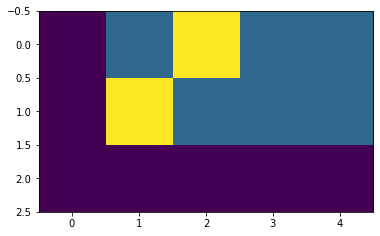

In [48]:
from pyitcast.transformer_utils import LabelSmoothing

# 使用LabelSmoothing实例化一个crit对象.
# 第一个参数size代表目标数据的词汇总数, 也是模型最后一层得到张量的最后一维大小
# 这里是5说明目标词汇总数是5个. 第二个参数padding_idx表示要将那些tensor中的数字
# 替换成0, 一般padding_idx=0表示不进行替换. 第三个参数smoothing, 表示标签的平滑程度
# 如原来标签的表示值为1, 则平滑后它的值域变为[1-smoothing, 1+smoothing].
crit = LabelSmoothing(size=5, padding_idx=0, smoothing=0.5)

# 假定一个任意的模型最后输出预测结果和真实结果
predict = torch.autograd.Variable(torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]]))

# 标签的表示值是0，1，2
target = torch.autograd.Variable(torch.LongTensor([2, 1, 0]))

# 将predict, target传入到对象中
crit(predict, target)

# 绘制标签平滑图像
plt.imshow(crit.true_dist)

## 6.3.运行模型进行训练和评估

In [49]:
# 导入模型单轮训练工具包run_epoch, 该工具将对模型使用给定的损失函数计算方法进行单轮参数更新.
# 并打印每轮参数更新的损失结果.
from pyitcast.transformer_utils import run_epoch

def run(model, loss, epochs=10):
    """模型训练函数, 共有三个参数, model代表将要进行训练的模型
       loss代表使用的损失计算方法, epochs代表模型训练的轮数"""

    # 遍历轮数
    for epoch in range(epochs):
        # 模型使用训练模式, 所有参数将被更新
        model.train()
        # 训练时, batch_size是20
        run_epoch(data_generator(V, 8, 20), model, loss)

        # 模型使用评估模式, 参数将不会变化 
        model.eval()
        # 评估时, batch_size是5
        run_epoch(data_generator(V, 8, 5), model, loss)

In [52]:
# 进行10轮训练
epochs = 10

# model和loss都是来自上一步的结果
run(model, loss, epochs)

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

## 6.4.使用模型进行贪婪解码

In [54]:
# 导入贪婪解码工具包greedy_decode, 该工具将对最终结进行贪婪解码
# 贪婪解码的方式是每次预测都选择概率最大的结果作为输出, 
# 它不一定能获得全局最优性, 但却拥有最高的执行效率.
from pyitcast.transformer_utils import greedy_decode 

def run(model, loss, epochs=10):
    for epoch in range(epochs):
        model.train()

        run_epoch(data_generator(V, 8, 20), model, loss)

        model.eval()

        run_epoch(data_generator(V, 8, 5), model, loss)

    # 模型进入测试模式
    model.eval()

    # 假定的输入张量
    source = torch.autograd.Variable(torch.LongTensor([[1,3,2,5,4,6,7,8,9,10]]))

    # 定义源数据掩码张量, 因为元素都是1, 在我们这里1代表不遮掩
    # 因此相当于对源数据没有任何遮掩.
    source_mask = torch.autograd.Variable(torch.ones(1, 1, 10))

    # 最后将model, src, src_mask, 解码的最大长度限制max_len, 默认为10
    # 以及起始标志数字, 默认为1, 我们这里使用的也是1
    result = greedy_decode(model, source, source_mask, max_len=10, start_symbol=1)
    print(result)


if __name__ == '__main__':
    run(model, loss) 

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number